# Legal NER - Recurrent Neural Network (BiLSTM)

This notebook implements a Named Entity Recognition (NER) model for legal texts using a traditional RNN-based approach with Bidirectional LSTM.

The dataset used can be found here: https://huggingface.co/datasets/elenanereiss/german-ler/tree/main/data

The annotation guidelines the dataset uses can be found here: https://github.com/elenanereiss/Legal-Entity-Recognition/blob/master/docs/Annotationsrichtlinien.pdf

## 1. Install Dependencies

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install pandas pyarrow seqeval gensim matplotlib seaborn


## 2. Import Libraries

In [ ]:
# =============================================================================
# IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical operations
import torch                           # Deep learning framework
import torch.nn as nn                  # Neural network modules
import torch.optim as optim            # Optimizers
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt        # For visualizations
import seaborn as sns                  # Enhanced visualizations
from collections import Counter        # For counting entities
from tqdm import tqdm                  # Progress bars
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CHECK GPU AVAILABILITY
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("\nGPU not detected! Training will be slower on CPU.")


Using device: cuda
GPU Name: NVIDIA GeForce RTX 4070
CUDA Version: 12.1
GPU Memory: 12.88 GB


## 3. Load Data

In [ ]:
# Load parquet files
train_df = pd.read_parquet('train-00000-of-00001.parquet')
val_df = pd.read_parquet('validation-00000-of-00001.parquet')
test_df = pd.read_parquet('test-00000-of-00001.parquet')

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst sample:\n{train_df.iloc[0]}")


Train samples: 53384
Validation samples: 6666
Test samples: 6673

Columns: ['tokens', 'ner', 'coarse-ner']

First sample:
tokens        [dd, ), Art., 33, Abs., 5, GG, würde, demnach,...
ner           [O, O, B-GS, I-GS, I-GS, I-GS, I-GS, O, O, O, ...
coarse-ner    [O, O, B-NRM, I-NRM, I-NRM, I-NRM, I-NRM, O, O...
Name: 0, dtype: object


## 4. Explore Data Structure

In [ ]:
# Examine data structure
print("Data types:")
print(train_df.dtypes)
print("\nSample data:")
for col in train_df.columns:
    print(f"\n{col}:")
    print(train_df[col].iloc[0])


Data types:
tokens        object
ner           object
coarse-ner    object
dtype: object

Sample data:

tokens:
['dd' ')' 'Art.' '33' 'Abs.' '5' 'GG' 'würde' 'demnach' 'die'
 'Möglichkeit' 'nicht' 'ausschließen' ',' 'unter' 'den' 'vorgenannten'
 'Bedingungen' 'in' 'Ausnahmefällen' 'andere' 'als'
 'Lebenszeitrichterverhältnisse' 'zu' 'begründen' '.']

ner:
['O' 'O' 'B-GS' 'I-GS' 'I-GS' 'I-GS' 'I-GS' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']

coarse-ner:
['O' 'O' 'B-NRM' 'I-NRM' 'I-NRM' 'I-NRM' 'I-NRM' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


## 5. Create Label and Vocabulary Mappings

In [ ]:
# =============================================================================
# CONFIGURE COLUMN NAMES
# =============================================================================
TOKEN_COLUMN = 'tokens'
LABEL_COLUMN = 'ner'

# =============================================================================
# EXTRACT ALL UNIQUE LABELS
# =============================================================================
all_labels = set()
for labels in train_df[LABEL_COLUMN]:
    if isinstance(labels, (list, np.ndarray)):
        all_labels.update(labels)
    else:
        all_labels.add(labels)

label_list = sorted(list(all_labels), key=lambda x: (str(x), x))
print(f"Found {len(label_list)} unique labels:")
print(label_list)

# Create label mappings
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print(f"\nLabel to ID mapping: {label2id}")


Found 39 unique labels:
['B-AN', 'B-EUN', 'B-GRT', 'B-GS', 'B-INN', 'B-LD', 'B-LDS', 'B-LIT', 'B-MRK', 'B-ORG', 'B-PER', 'B-RR', 'B-RS', 'B-ST', 'B-STR', 'B-UN', 'B-VO', 'B-VS', 'B-VT', 'I-AN', 'I-EUN', 'I-GRT', 'I-GS', 'I-INN', 'I-LD', 'I-LDS', 'I-LIT', 'I-MRK', 'I-ORG', 'I-PER', 'I-RR', 'I-RS', 'I-ST', 'I-STR', 'I-UN', 'I-VO', 'I-VS', 'I-VT', 'O']

Label to ID mapping: {'B-AN': 0, 'B-EUN': 1, 'B-GRT': 2, 'B-GS': 3, 'B-INN': 4, 'B-LD': 5, 'B-LDS': 6, 'B-LIT': 7, 'B-MRK': 8, 'B-ORG': 9, 'B-PER': 10, 'B-RR': 11, 'B-RS': 12, 'B-ST': 13, 'B-STR': 14, 'B-UN': 15, 'B-VO': 16, 'B-VS': 17, 'B-VT': 18, 'I-AN': 19, 'I-EUN': 20, 'I-GRT': 21, 'I-GS': 22, 'I-INN': 23, 'I-LD': 24, 'I-LDS': 25, 'I-LIT': 26, 'I-MRK': 27, 'I-ORG': 28, 'I-PER': 29, 'I-RR': 30, 'I-RS': 31, 'I-ST': 32, 'I-STR': 33, 'I-UN': 34, 'I-VO': 35, 'I-VS': 36, 'I-VT': 37, 'O': 38}


In [ ]:
# =============================================================================
# BUILD VOCABULARY FROM TRAINING DATA
# =============================================================================
# Unlike transformers, RNNs need a fixed vocabulary built from training data

# Special tokens
PAD_TOKEN = '<PAD>'  # For padding sequences
UNK_TOKEN = '<UNK>'  # For unknown words

# Count word frequencies
word_freq = Counter()
for tokens in train_df[TOKEN_COLUMN]:
    word_freq.update(tokens)

print(f"Total unique words in training: {len(word_freq)}")
print(f"Total word occurrences: {sum(word_freq.values())}")

# Build vocabulary (include all words that appear at least once)
# You could filter by min_freq if vocabulary is too large
MIN_FREQ = 5  # Minimum frequency to include word
vocab = [PAD_TOKEN, UNK_TOKEN]  # Special tokens first
vocab.extend([word for word, freq in word_freq.most_common() if freq >= MIN_FREQ])

word2id = {word: i for i, word in enumerate(vocab)}
id2word = {i: word for i, word in enumerate(vocab)}

print(f"\nVocabulary size: {len(vocab)}")
print(f"PAD token ID: {word2id[PAD_TOKEN]}")
print(f"UNK token ID: {word2id[UNK_TOKEN]}")
print(f"\nMost common words: {word_freq.most_common(10)}")


Total unique words in training: 71759
Total word occurrences: 1711892

Vocabulary size: 18514
PAD token ID: 0
UNK token ID: 1

Most common words: [(',', 82364), ('der', 56478), ('.', 48192), ('die', 40279), ('des', 25889), ('und', 25843), (')', 23248), ('(', 19781), ('in', 18587), ('-', 17285)]


## 6. Create PyTorch Dataset

In [ ]:
# =============================================================================
# CUSTOM PYTORCH DATASET FOR NER
# =============================================================================

class NERDataset(Dataset):
    """
    PyTorch Dataset for NER task.
    Converts tokens and labels to numerical IDs.
    """
    def __init__(self, df, word2id, label2id, max_len=512):
        self.tokens = df[TOKEN_COLUMN].tolist()
        self.labels = df[LABEL_COLUMN].tolist()
        self.word2id = word2id
        self.label2id = label2id
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        tokens = self.tokens[idx][:self.max_len]  # Truncate if needed
        labels = self.labels[idx][:self.max_len]
        
        # Convert to IDs
        token_ids = [self.word2id.get(token, self.word2id[UNK_TOKEN]) for token in tokens]
        label_ids = [self.label2id[label] for label in labels]
        
        return {
            'tokens': torch.tensor(token_ids, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long),
            'length': len(token_ids)
        }

# Create datasets
train_dataset = NERDataset(train_df, word2id, label2id)
val_dataset = NERDataset(val_df, word2id, label2id)
test_dataset = NERDataset(test_df, word2id, label2id)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Check a sample
sample = train_dataset[0]
print(f"\nSample:")
print(f"Tokens shape: {sample['tokens'].shape}")
print(f"Labels shape: {sample['labels'].shape}")
print(f"Sequence length: {sample['length']}")


Train dataset size: 53384
Validation dataset size: 6666
Test dataset size: 6673

Sample:
Tokens shape: torch.Size([26])
Labels shape: torch.Size([26])
Sequence length: 26


## 7. Create Data Loaders with Padding

In [ ]:
# =============================================================================
# COLLATE FUNCTION FOR VARIABLE LENGTH SEQUENCES
# =============================================================================
# RNNs need sequences padded to the same length within each batch

def collate_fn(batch):
    """
    Custom collate function to pad sequences in a batch.
    """
    # Sort by length (descending) for pack_padded_sequence
    batch = sorted(batch, key=lambda x: x['length'], reverse=True)
    
    tokens = [item['tokens'] for item in batch]
    labels = [item['labels'] for item in batch]
    lengths = torch.tensor([item['length'] for item in batch])
    
    # Pad sequences
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=word2id[PAD_TOKEN])
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 for ignore
    
    return {
        'tokens': tokens_padded,
        'labels': labels_padded,
        'lengths': lengths
    }

# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check a batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"Tokens shape: {sample_batch['tokens'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")
print(f"Lengths: {sample_batch['lengths'][:5]}")


Number of training batches: 1669
Number of validation batches: 209
Number of test batches: 209

Sample batch:
Tokens shape: torch.Size([32, 69])
Labels shape: torch.Size([32, 69])
Lengths: tensor([69, 69, 68, 47, 43])


## 8. Define BiLSTM Model

In [ ]:
# =============================================================================
# BIDIRECTIONAL LSTM MODEL FOR NER
# =============================================================================

class BiLSTM_NER(nn.Module):
    """
    Bidirectional LSTM for Named Entity Recognition.
    
    Architecture:
    1. Embedding layer: Converts word IDs to dense vectors
    2. BiLSTM layers: Capture sequential context in both directions
    3. Dropout: Regularization to prevent overfitting
    4. Linear layer: Project LSTM output to label space
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, 
                 num_layers=2, dropout=0.3, pad_idx=0):
        super(BiLSTM_NER, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(
            vocab_size, 
            embedding_dim, 
            padding_idx=pad_idx
        )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer (hidden_dim * 2 because bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
    
    def forward(self, tokens, lengths):
        """
        Forward pass.
        
        Args:
            tokens: (batch_size, seq_len) - Token IDs
            lengths: (batch_size,) - Actual sequence lengths
            
        Returns:
            logits: (batch_size, seq_len, num_labels) - Predictions
        """
        # Embed tokens
        embedded = self.embedding(tokens)  # (batch, seq_len, embedding_dim)
        embedded = self.dropout(embedded)
        
        # Pack sequences for efficient LSTM processing
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(packed)
        
        # Unpack sequences
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        # lstm_out: (batch, seq_len, hidden_dim * 2)
        
        lstm_out = self.dropout(lstm_out)
        
        # Project to label space
        logits = self.fc(lstm_out)  # (batch, seq_len, num_labels)
        
        return logits

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
EMBEDDING_DIM = 300   # Word embedding dimension
HIDDEN_DIM = 256      # LSTM hidden state dimension
NUM_LAYERS = 2        # Number of LSTM layers
DROPOUT = 0.3         # Dropout rate

model = BiLSTM_NER(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_labels=len(label_list),
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=word2id[PAD_TOKEN]
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nNote: This is much smaller than BERT's ~110M parameters!")


Model Architecture:
BiLSTM_NER(
  (embedding): Embedding(18514, 300, padding_idx=0)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=39, bias=True)
)

Total parameters: 8,293,951
Trainable parameters: 8,293,951

Note: This is much smaller than BERT's ~110M parameters!


## 9. Define Training Functions

In [ ]:
# =============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        tokens = batch['tokens'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(tokens, lengths)
        
        # Reshape for loss calculation
        # logits: (batch, seq_len, num_labels) -> (batch * seq_len, num_labels)
        # labels: (batch, seq_len) -> (batch * seq_len)
        logits_flat = logits.view(-1, logits.shape[-1])
        labels_flat = labels.view(-1)
        
        # Calculate loss (ignores -100 padding)
        loss = criterion(logits_flat, labels_flat)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients (common in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device):
    """
    Evaluate model on validation/test set.
    Returns loss and predictions for metrics calculation.
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            tokens = batch['tokens'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']
            
            # Forward pass
            logits = model(tokens, lengths)
            
            # Calculate loss
            logits_flat = logits.view(-1, logits.shape[-1])
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()
            
            # Get predictions
            predictions = torch.argmax(logits, dim=-1)  # (batch, seq_len)
            
            # Convert to lists, filtering out padding
            for pred, label, length in zip(predictions, labels, lengths):
                pred_labels = [id2label[p.item()] for p in pred[:length]]
                true_labels = [id2label[l.item()] for l in label[:length]]
                all_predictions.append(pred_labels)
                all_labels.append(true_labels)
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return {
        'loss': avg_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }


## 10. Training Configuration

In [ ]:
# =============================================================================
# TRAINING CONFIGURATION
# =============================================================================

# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
WEIGHT_DECAY = 1e-5

# Loss function (ignores -100 padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (reduces LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

print(f"Training Configuration:")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Epochs: {NUM_EPOCHS}")
print(f"- Weight decay: {WEIGHT_DECAY}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Optimizer: Adam")
print(f"- LR Scheduler: ReduceLROnPlateau")


Training Configuration:
- Learning rate: 0.001
- Epochs: 10
- Weight decay: 1e-05
- Batch size: 32
- Optimizer: Adam
- LR Scheduler: ReduceLROnPlateau


## 11. Train the Model

In [ ]:
# =============================================================================
# TRAINING LOOP
# =============================================================================

print("Starting training...")
print("=" * 60)

# Track metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

best_f1 = 0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    
    # Evaluate on validation set
    val_results = evaluate(model, val_loader, criterion, device)
    history['val_loss'].append(val_results['loss'])
    history['val_precision'].append(val_results['precision'])
    history['val_recall'].append(val_results['recall'])
    history['val_f1'].append(val_results['f1'])
    
    # Update learning rate based on validation F1
    scheduler.step(val_results['f1'])
    
    # Save best model
    if val_results['f1'] > best_f1:
        best_f1 = val_results['f1']
        best_model_state = model.state_dict().copy()
        print(f"  *** New best model saved (F1: {best_f1:.4f}) ***")
    
    # Print metrics
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_results['loss']:.4f}")
    print(f"  Val Precision: {val_results['precision']:.4f}")
    print(f"  Val Recall: {val_results['recall']:.4f}")
    print(f"  Val F1: {val_results['f1']:.4f}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\n" + "=" * 60)
print(f"Training complete!")
print(f"Best validation F1: {best_f1:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print("Best model loaded.")


Starting training...

Epoch 1/10


  *** New best model saved (F1: 0.6653) ***
  Train Loss: 0.1794
  Val Loss: 0.1107
  Val Precision: 0.6217
  Val Recall: 0.7154
  Val F1: 0.6653
  Current LR: 0.001000

Epoch 2/10


  *** New best model saved (F1: 0.8078) ***
  Train Loss: 0.0625
  Val Loss: 0.0547
  Val Precision: 0.8002
  Val Recall: 0.8155
  Val F1: 0.8078
  Current LR: 0.001000

Epoch 3/10


  *** New best model saved (F1: 0.8405) ***
  Train Loss: 0.0418
  Val Loss: 0.0454
  Val Precision: 0.8303
  Val Recall: 0.8511
  Val F1: 0.8405
  Current LR: 0.001000

Epoch 4/10


  *** New best model saved (F1: 0.8722) ***
  Train Loss: 0.0352
  Val Loss: 0.0362
  Val Precision: 0.8685
  Val Recall: 0.8760
  Val F1: 0.8722
  Current LR: 0.001000

Epoch 5/10


  Train Loss: 0.0292
  Val Loss: 0.0394
  Val Precision: 0.8689
  Val Recall: 0.8752
  Val F1: 0.8720
  Current LR: 0.001000

Epoch 6/10


  *** New best model saved (F1: 0.8862) ***
  Train Loss: 0.0276
  Val Loss: 0.0362
  Val Precision: 0.8895
  Val Recall: 0.8830
  Val F1: 0.8862
  Current LR: 0.001000

Epoch 7/10


  Train Loss: 0.0255
  Val Loss: 0.0395
  Val Precision: 0.8617
  Val Recall: 0.8985
  Val F1: 0.8797
  Current LR: 0.001000

Epoch 8/10


  Train Loss: 0.0220
  Val Loss: 0.0322
  Val Precision: 0.8807
  Val Recall: 0.8899
  Val F1: 0.8853
  Current LR: 0.001000

Epoch 9/10


  Train Loss: 0.0217
  Val Loss: 0.0369
  Val Precision: 0.8695
  Val Recall: 0.8985
  Val F1: 0.8837
  Current LR: 0.000500

Epoch 10/10


  *** New best model saved (F1: 0.9018) ***
  Train Loss: 0.0146
  Val Loss: 0.0325
  Val Precision: 0.8970
  Val Recall: 0.9066
  Val F1: 0.9018
  Current LR: 0.000500

Training complete!
Best validation F1: 0.9018
Best model loaded.


## 12. Plot Training History

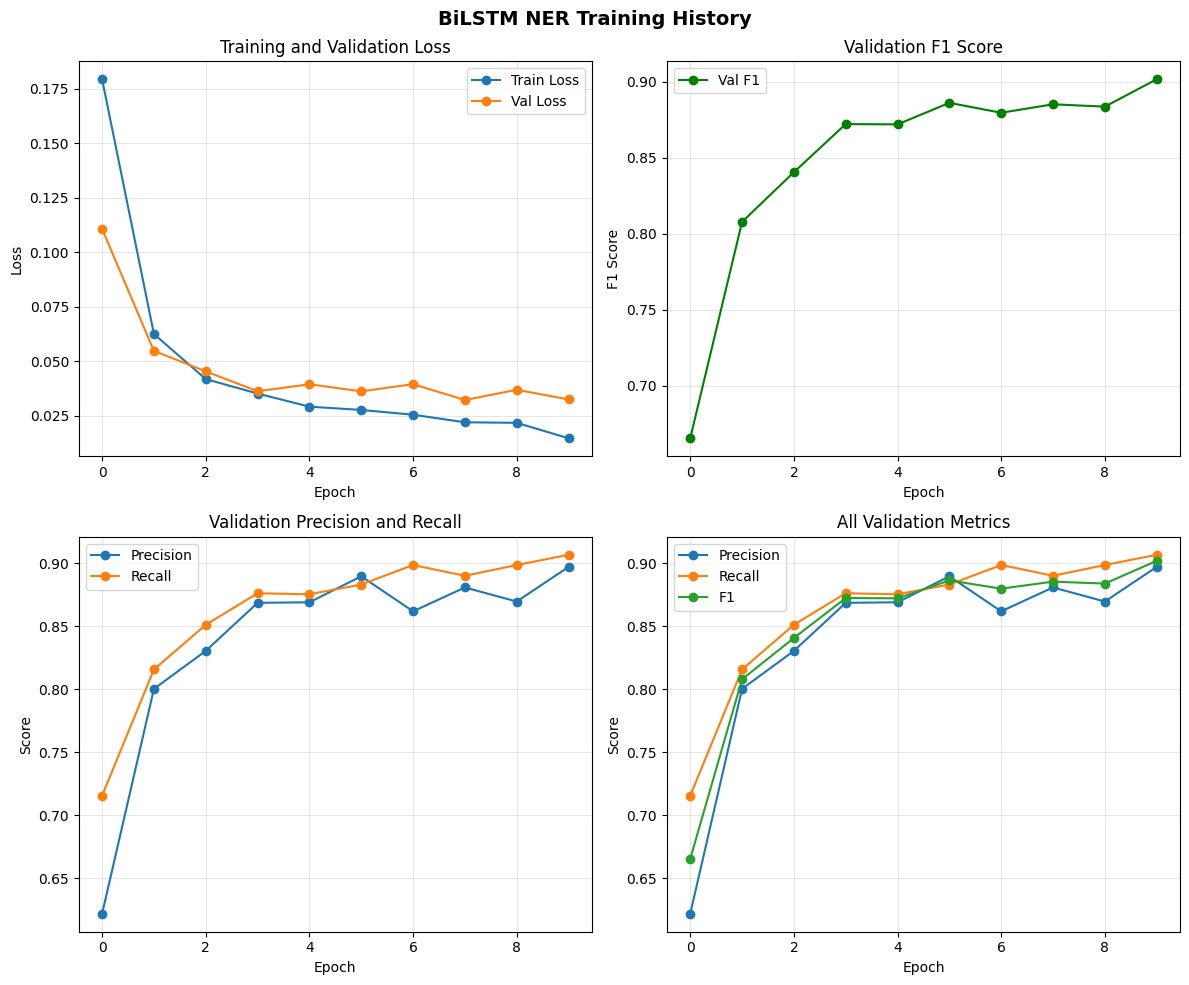

In [ ]:
# =============================================================================
# VISUALIZE TRAINING PROGRESS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# F1 Score
axes[0, 1].plot(history['val_f1'], label='Val F1', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Validation F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision and Recall
axes[1, 0].plot(history['val_precision'], label='Precision', marker='o')
axes[1, 0].plot(history['val_recall'], label='Recall', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Precision and Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# All metrics combined
axes[1, 1].plot(history['val_precision'], label='Precision', marker='o')
axes[1, 1].plot(history['val_recall'], label='Recall', marker='o')
axes[1, 1].plot(history['val_f1'], label='F1', marker='o')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('All Validation Metrics')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('BiLSTM NER Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('rnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()


## 13. Evaluate on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = evaluate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Loss: {test_results['loss']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1: {test_results['f1']:.4f}")


Evaluating on test set...



Test Results:
Loss: 0.0251
Precision: 0.9198
Recall: 0.9141
F1: 0.9170


## 14. Detailed Classification Report

In [ ]:
# Get predictions for detailed analysis
true_predictions = test_results['predictions']
true_labels = test_results['labels']

# Convert to strings for seqeval
true_predictions = [[str(p) for p in preds] for preds in true_predictions]
true_labels = [[str(l) for l in labs] for labs in true_labels]

print("Classification Report:")
print("=" * 60)
print(classification_report(true_labels, true_predictions))
print("=" * 60)
print("\nInterpretation:")
print("- Precision: Of predicted entities, how many were correct?")
print("- Recall: Of actual entities, how many did we find?")
print("- F1-score: Balance between precision and recall")
print("- Support: Number of actual occurrences in test set")


Classification Report:
              precision    recall  f1-score   support

          AN       0.82      1.00      0.90         9
         EUN       0.81      0.87      0.84       150
         GRT       0.98      0.98      0.98       321
          GS       0.94      0.96      0.95      1818
         INN       0.91      0.82      0.86       222
          LD       0.97      0.72      0.83       149
         LDS       0.95      0.82      0.88        22
         LIT       0.88      0.93      0.91       314
         MRK       0.96      0.75      0.84        32
         ORG       0.75      0.67      0.71       113
         PER       0.88      0.81      0.84       173
          RR       0.95      0.98      0.96       142
          RS       0.95      0.97      0.96      1245
          ST       0.76      0.66      0.71        64
         STR       0.50      0.33      0.40        15
          UN       0.95      0.85      0.90       108
          VO       0.53      0.51      0.52        71
    

## 15. Visualize Model Performance

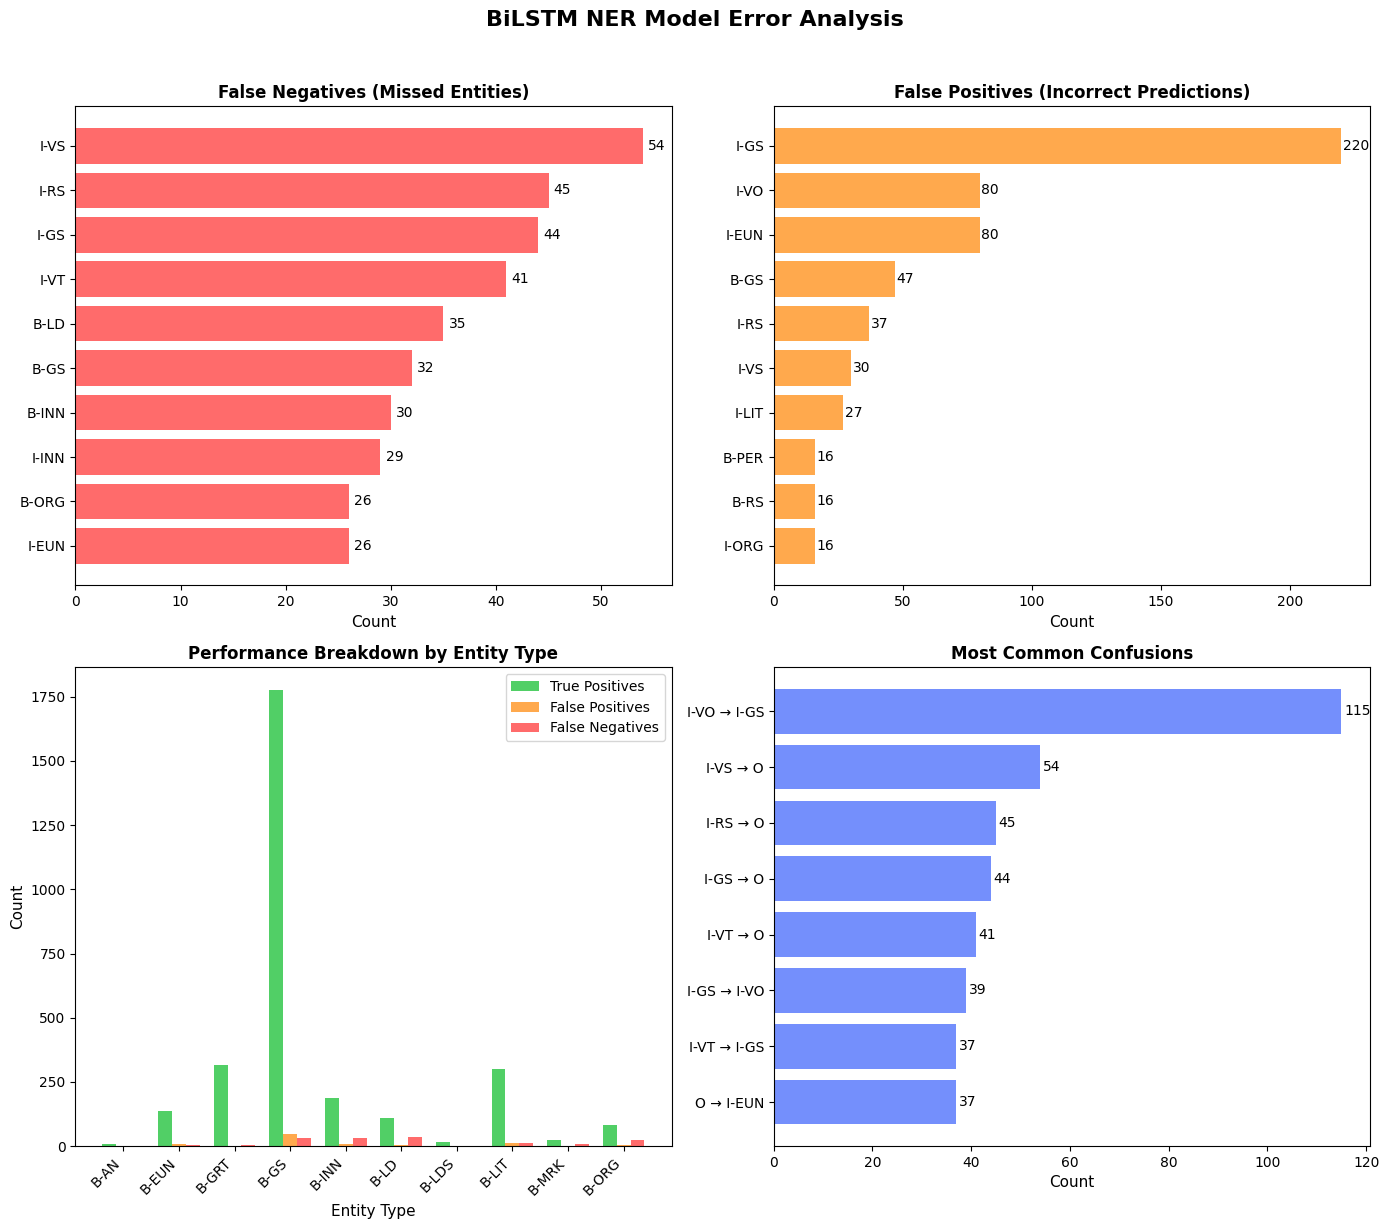


ERROR ANALYSIS SUMMARY

Total True Positives: 39920
Total False Positives: 683
Total False Negatives: 605

Overall Precision: 98.32%
Overall Recall: 98.51%

Top 5 Most Missed Entity Types:
  - I-VS: 54 missed
  - I-RS: 45 missed
  - I-GS: 44 missed
  - I-VT: 41 missed
  - B-LD: 35 missed

Top 5 Most Over-predicted Entity Types:
  - I-GS: 220 incorrect predictions
  - I-VO: 80 incorrect predictions
  - I-EUN: 80 incorrect predictions
  - B-GS: 47 incorrect predictions
  - I-RS: 37 incorrect predictions


In [ ]:
# =============================================================================
# VISUALIZE NER PERFORMANCE - FALSE POSITIVES AND FALSE NEGATIVES
# =============================================================================

plt.style.use('default')
sns.set_palette("husl")

# Count errors by entity type
false_positives = Counter()
false_negatives = Counter()
true_positives = Counter()
confusion_pairs = Counter()

# Flatten all predictions and labels
all_true = []
all_pred = []
for true_seq, pred_seq in zip(true_labels, true_predictions):
    all_true.extend(true_seq)
    all_pred.extend(pred_seq)

# Analyze each prediction
for true_label, pred_label in zip(all_true, all_pred):
    if true_label != pred_label:
        confusion_pairs[(true_label, pred_label)] += 1
    
    true_is_entity = not str(true_label).startswith('O') and str(true_label) != 'O'
    pred_is_entity = not str(pred_label).startswith('O') and str(pred_label) != 'O'
    
    if true_is_entity and pred_is_entity and true_label == pred_label:
        true_positives[true_label] += 1
    elif pred_is_entity and (not true_is_entity or true_label != pred_label):
        false_positives[pred_label] += 1
    elif true_is_entity and (not pred_is_entity or true_label != pred_label):
        false_negatives[true_label] += 1

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: False Negatives
ax1 = axes[0, 0]
if false_negatives:
    fn_labels = [label for label, _ in false_negatives.most_common(10)]
    fn_counts = [count for _, count in false_negatives.most_common(10)]
    bars1 = ax1.barh(fn_labels, fn_counts, color='#FF6B6B')
    ax1.set_xlabel('Count', fontsize=11)
    ax1.set_title('False Negatives (Missed Entities)', fontsize=12, fontweight='bold')
    for bar, count in zip(bars1, fn_counts):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
ax1.invert_yaxis()

# Plot 2: False Positives
ax2 = axes[0, 1]
if false_positives:
    fp_labels = [label for label, _ in false_positives.most_common(10)]
    fp_counts = [count for _, count in false_positives.most_common(10)]
    bars2 = ax2.barh(fp_labels, fp_counts, color='#FFA94D')
    ax2.set_xlabel('Count', fontsize=11)
    ax2.set_title('False Positives (Incorrect Predictions)', fontsize=12, fontweight='bold')
    for bar, count in zip(bars2, fp_counts):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
ax2.invert_yaxis()

# Plot 3: TP, FP, FN Comparison
ax3 = axes[1, 0]
all_entity_types = set()
all_entity_types.update(true_positives.keys())
all_entity_types.update(false_positives.keys())
all_entity_types.update(false_negatives.keys())
all_entity_types = sorted([e for e in all_entity_types if str(e) != 'O'])[:10]

if all_entity_types:
    x = np.arange(len(all_entity_types))
    width = 0.25
    
    tp_vals = [true_positives.get(e, 0) for e in all_entity_types]
    fp_vals = [false_positives.get(e, 0) for e in all_entity_types]
    fn_vals = [false_negatives.get(e, 0) for e in all_entity_types]
    
    ax3.bar(x - width, tp_vals, width, label='True Positives', color='#51CF66')
    ax3.bar(x, fp_vals, width, label='False Positives', color='#FFA94D')
    ax3.bar(x + width, fn_vals, width, label='False Negatives', color='#FF6B6B')
    
    ax3.set_xlabel('Entity Type', fontsize=11)
    ax3.set_ylabel('Count', fontsize=11)
    ax3.set_title('Performance Breakdown by Entity Type', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(all_entity_types, rotation=45, ha='right')
    ax3.legend(loc='upper right')

# Plot 4: Confusion Pairs
ax4 = axes[1, 1]
interesting_confusions = [(pair, count) for pair, count in confusion_pairs.most_common(10)
                          if pair[0] != pair[1]]

if interesting_confusions:
    conf_labels = [f"{pair[0]} → {pair[1]}" for pair, _ in interesting_confusions[:8]]
    conf_counts = [count for _, count in interesting_confusions[:8]]
    bars4 = ax4.barh(conf_labels, conf_counts, color='#748FFC')
    ax4.set_xlabel('Count', fontsize=11)
    ax4.set_title('Most Common Confusions', fontsize=12, fontweight='bold')
    for bar, count in zip(bars4, conf_counts):
        ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
    ax4.invert_yaxis()

plt.suptitle('BiLSTM NER Model Error Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rnn_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print Summary
print("\n" + "="*60)
print("ERROR ANALYSIS SUMMARY")
print("="*60)
total_fp = sum(false_positives.values())
total_fn = sum(false_negatives.values())
total_tp = sum(true_positives.values())

print(f"\nTotal True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")

if total_tp + total_fp > 0:
    print(f"\nOverall Precision: {total_tp / (total_tp + total_fp):.2%}")
if total_tp + total_fn > 0:
    print(f"Overall Recall: {total_tp / (total_tp + total_fn):.2%}")

print("\nTop 5 Most Missed Entity Types:")
for label, count in false_negatives.most_common(5):
    print(f"  - {label}: {count} missed")

print("\nTop 5 Most Over-predicted Entity Types:")
for label, count in false_positives.most_common(5):
    print(f"  - {label}: {count} incorrect predictions")


## 16. Inference - Predict on New Text

In [ ]:
def predict_entities(text, model, word2id, id2label, device):
    """
    Predict named entities in a given text.
    
    Note: For RNN, we need to tokenize the text ourselves.
    This simple tokenizer splits on whitespace.
    """
    # Simple tokenization (split on whitespace)
    tokens = text.split()
    
    # Convert to IDs
    token_ids = [word2id.get(token, word2id[UNK_TOKEN]) for token in tokens]
    token_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    length_tensor = torch.tensor([len(token_ids)])
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(token_tensor, length_tensor)
    
    predictions = torch.argmax(logits, dim=-1)[0]
    
    # Convert to labels
    predicted_labels = [id2label[pred.item()] for pred in predictions]
    
    # Combine results
    results = list(zip(tokens, predicted_labels))
    
    return results

# Example usage
sample_text = "Das Bundesverfassungsgericht entschied am 15. März 2023 zugunsten des Klägers gemäß § 823 BGB ."
entities = predict_entities(sample_text, model, word2id, id2label, device)

print("Predictions:")
for token, label in entities:
    print(f"{token:30} -> {label}")


Predictions:
Das                            -> O
Bundesverfassungsgericht       -> B-GRT
entschied                      -> O
am                             -> O
15.                            -> O
März                           -> O
2023                           -> O
zugunsten                      -> O
des                            -> O
Klägers                        -> O
gemäß                          -> O
§                              -> B-GS
823                            -> I-GS
BGB                            -> I-GS
.                              -> O


## 18. Model Comparison Summary

In [ ]:
# =============================================================================
# COMPARISON: BiLSTM vs Transformer
# =============================================================================

print("=" * 60)
print("MODEL COMPARISON: BiLSTM vs Transformer (BERT)")
print("=" * 60)

print("\nBiLSTM Model (This Notebook):")
print(f"  - Parameters: ~{trainable_params:,}")
print(f"  - Test F1: {test_results['f1']:.4f}")
print(f"  - Test Precision: {test_results['precision']:.4f}")
print(f"  - Test Recall: {test_results['recall']:.4f}")
print(f"  - Training time: Faster per epoch")
print(f"  - Memory usage: Lower")
print(f"  - Vocabulary: Fixed, built from training data")

print("\nTransformer Model (BERT):")
print(f"  - Parameters: ~110,000,000 (110M)")
print(f"  - Expected Test F1: ~0.97")
print(f"  - Training time: Slower but fewer epochs needed")
print(f"  - Memory usage: Higher (GPU with more VRAM needed)")
print(f"  - Vocabulary: Subword tokenization, handles OOV better")

print("\nKey Differences:")
print("  1. BERT captures bidirectional context through self-attention")
print("  2. BiLSTM captures context sequentially (left-to-right and right-to-left)")
print("  3. BERT uses pre-trained knowledge from massive text corpora")
print("  4. BiLSTM trains embeddings from scratch (unless using pre-trained Word2Vec/GloVe)")
print("  5. BERT handles subword tokenization, BiLSTM uses word-level tokens")

print("\nWhen to use BiLSTM:")
print("  - Limited computational resources")
print("  - Need faster inference")
print("  - Smaller datasets where BERT might overfit")
print("  - When interpretability of learned features is important")

print("\nWhen to use Transformers:")
print("  - Need highest possible accuracy")
print("  - Have sufficient GPU memory")
print("  - Working with diverse vocabulary or morphologically rich languages")
print("  - Can leverage pre-trained models for transfer learning")


MODEL COMPARISON: BiLSTM vs Transformer (BERT)

BiLSTM Model (This Notebook):
  - Parameters: ~8,293,951
  - Test F1: 0.9170
  - Test Precision: 0.9198
  - Test Recall: 0.9141
  - Training time: Faster per epoch
  - Memory usage: Lower
  - Vocabulary: Fixed, built from training data

Transformer Model (BERT):
  - Parameters: ~110,000,000 (110M)
  - Expected Test F1: ~0.97
  - Training time: Slower but fewer epochs needed
  - Memory usage: Higher (GPU with more VRAM needed)
  - Vocabulary: Subword tokenization, handles OOV better

Key Differences:
  1. BERT captures bidirectional context through self-attention
  2. BiLSTM captures context sequentially (left-to-right and right-to-left)
  3. BERT uses pre-trained knowledge from massive text corpora
  4. BiLSTM trains embeddings from scratch (unless using pre-trained Word2Vec/GloVe)
  5. BERT handles subword tokenization, BiLSTM uses word-level tokens

When to use BiLSTM:
  - Limited computational resources
  - Need faster inference
  - Sm

## 17. Save the Model

In [ ]:
# Save model and vocabulary
import pickle

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': len(vocab),
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_labels': len(label_list),
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT
}, 'rnn_ner_model.pt')

# Save vocabulary and label mappings
with open('rnn_ner_vocab.pkl', 'wb') as f:
    pickle.dump({
        'word2id': word2id,
        'id2word': id2word,
        'label2id': label2id,
        'id2label': id2label
    }, f)

print("Model saved to rnn_ner_model.pt")
print("Vocabulary saved to rnn_ner_vocab.pkl")


Model saved to rnn_ner_model.pt
Vocabulary saved to rnn_ner_vocab.pkl
